Dogs vs Cats 

data url: https://www.kaggle.com/c/dogs-vs-cats/data?select=train.zip

In [ ]:
!mkdir data
!mkdir models
!mkdir testing
!mkdir data/dogs-vs-cats

In [23]:
!pwd

In [ ]:
import zipfile

with zipfile.ZipFile("train.zip", "r") as zip_ref:
    zip_ref.extractall("data/")

with zipfile.ZipFile("test1.zip", "r") as zip_ref:
  zip_ref.extractall("data/")

In [25]:
!mkdir data/train/dogs
!mkdir data/train/cats

mkdir: cannot create directory ‘data/train/dogs’: File exists
mkdir: cannot create directory ‘data/train/cats’: File exists


In [26]:
!mv data/train/cat*.jpg data/train/cats/
!mv data/train/dog*.jpg data/train/dogs/

In [2]:
!wget --no-check-certificate \
  "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5" \
  -O models/inception_v3.h5

--2024-11-04 16:25:19--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 2a00:1450:4017:803::201b, 2a00:1450:4017:80e::201b, 2a00:1450:4017:80c::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2a00:1450:4017:803::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘models/inception_v3.h5’

models/inception_v3 100%[===================>]  83,84M  25,7MB/s    in 3,9s    

2024-11-04 16:25:23 (21,8 MB/s) - ‘models/inception_v3.h5’ saved [87910968/87910968]



In [4]:
import urllib

import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image


Matplotlib is building the font cache; this may take a moment.


In [5]:

class AccuracyLoggingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epochs = []
        self.accuracy = []
        self.val_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        # Store the epoch number and accuracy values
        self.epochs.append(epoch + 1)
        self.accuracy.append(logs.get("acc"))
        self.val_accuracy.append(logs.get("val_acc"))
        # Print the values for reference
        print(f"\nEpoch {epoch + 1}: Accuracy = {self.accuracy[-1]:.4f}, Validation Accuracy = {self.val_accuracy[-1]:.4f}")

model_accuracy = AccuracyLoggingCallback()

Load training data

In [8]:
model_path = 'models/binary-classifier-cats-and-dogs.keras'
training_dir = 'data/dogs-vs-cats/training/'

In [12]:
data = keras.utils.image_dataset_from_directory(
    training_dir,
    labels='inferred',
    label_mode='int',
    image_size=(150,150),
    shuffle=True
)

validation_size = int(0.2 * len(data))
training_data = data.skip(validation_size)
validation_data = data.take(validation_size)



print(len(training_data) * 32)
print(len(validation_data) * 32)
print(len(training_data) * 32 + len(validation_data) * 32)


Found 25000 files belonging to 2 classes.
20032
4992
25024


Normalize data

In [13]:
normalization_layer = keras.layers.Rescaling(1./255)

training_data = training_data.map(lambda x, y: (normalization_layer(x), y))
validation_data = validation_data.map(lambda x, y: (normalization_layer(x), y))

Augment training data

In [11]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
])

training_data = training_data.map(lambda x, y: (data_augmentation(x), y))


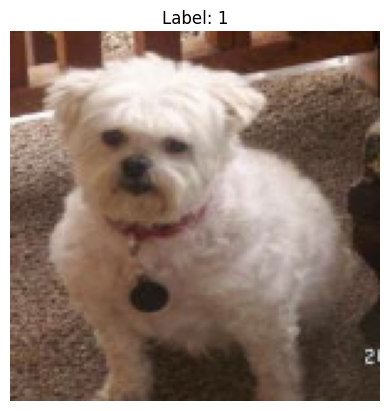

In [14]:
for images, labels in data.take(8):  # Take 1 batch
    # Get the first image and label from the batch
    first_image = images[0].numpy().astype("uint8")
    first_label = labels[0].numpy()

    # Plot the image
    plt.imshow(first_image)
    plt.title(f"Label: {first_label}")
    plt.axis("off")  # Turn off axis
    plt.show()
    break

Initialize InceptionV3 model, load weights, and make untrainable.

In [15]:
weights_file = "models/inception_v3.h5"

pre_trained_model = InceptionV3(input_shape=(150,150,3), include_top=False, weights=None)

pre_trained_model.load_weights(weights_file)

for layer in pre_trained_model.layers:
        layer.trainable = False


In [ ]:
pre_trained_model.summary()

Get model up to mixed7 layer and append our model

In [16]:
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(pre_trained_model.input, x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
                loss='binary_crossentropy',
                metrics=['acc'])



Train model

In [17]:
model.fit(training_data, epochs=30, validation_data=validation_data, callbacks=[model_accuracy])

Epoch 1/30
 28/626 ━━━━━━━━━━━━━━━━━━━━ 3:21 337ms/step - acc: 0.7648 - loss: 0.5544

KeyboardInterrupt: 

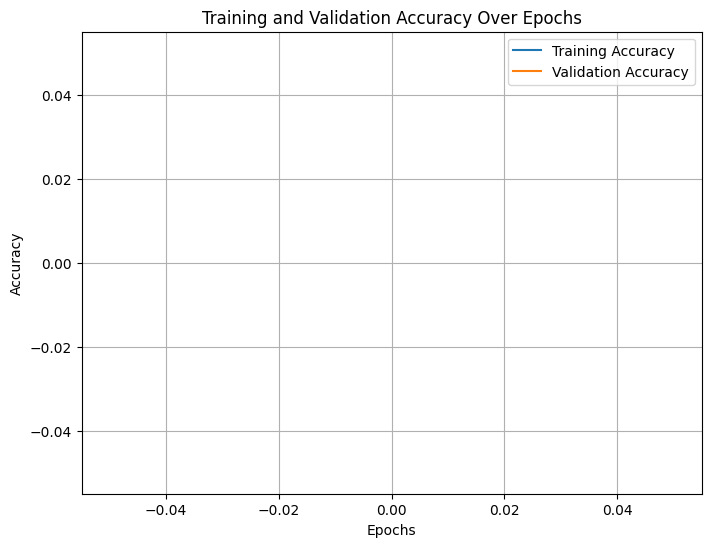

In [18]:
# Convert lists to numpy arrays for easy plotting
epochs = np.array(model_accuracy.epochs)
accuracy = np.array(model_accuracy.accuracy)
val_accuracy = np.array(model_accuracy.val_accuracy)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, label="Training Accuracy")
plt.plot(epochs, val_accuracy, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save(model_path)

In [ ]:
import numpy as np
from google.colab import files

uploaded = files.upload('testing/')

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  y = image.img_to_array(img)
  y = np.expand_dims(y, axis=0)

  images = np.vstack([y])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a Dog")
  else:
    print(fn + " is a Cat")


Saving 1.jpg to testing/1.jpg
Saving 2.jpg to testing/2.jpg
Saving 3.jpg to testing/3.jpg
Saving 4.jpg to testing/4.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.7288642]
testing/1.jpg is a Dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.8602098]
testing/2.jpg is a Dog
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.00963066]
testing/3.jpg is a Cat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[0.8930866]
testing/4.jpg is a Dog


Clean up imports

In [ ]:
!rm testing/*.jpg